# Naive RAG

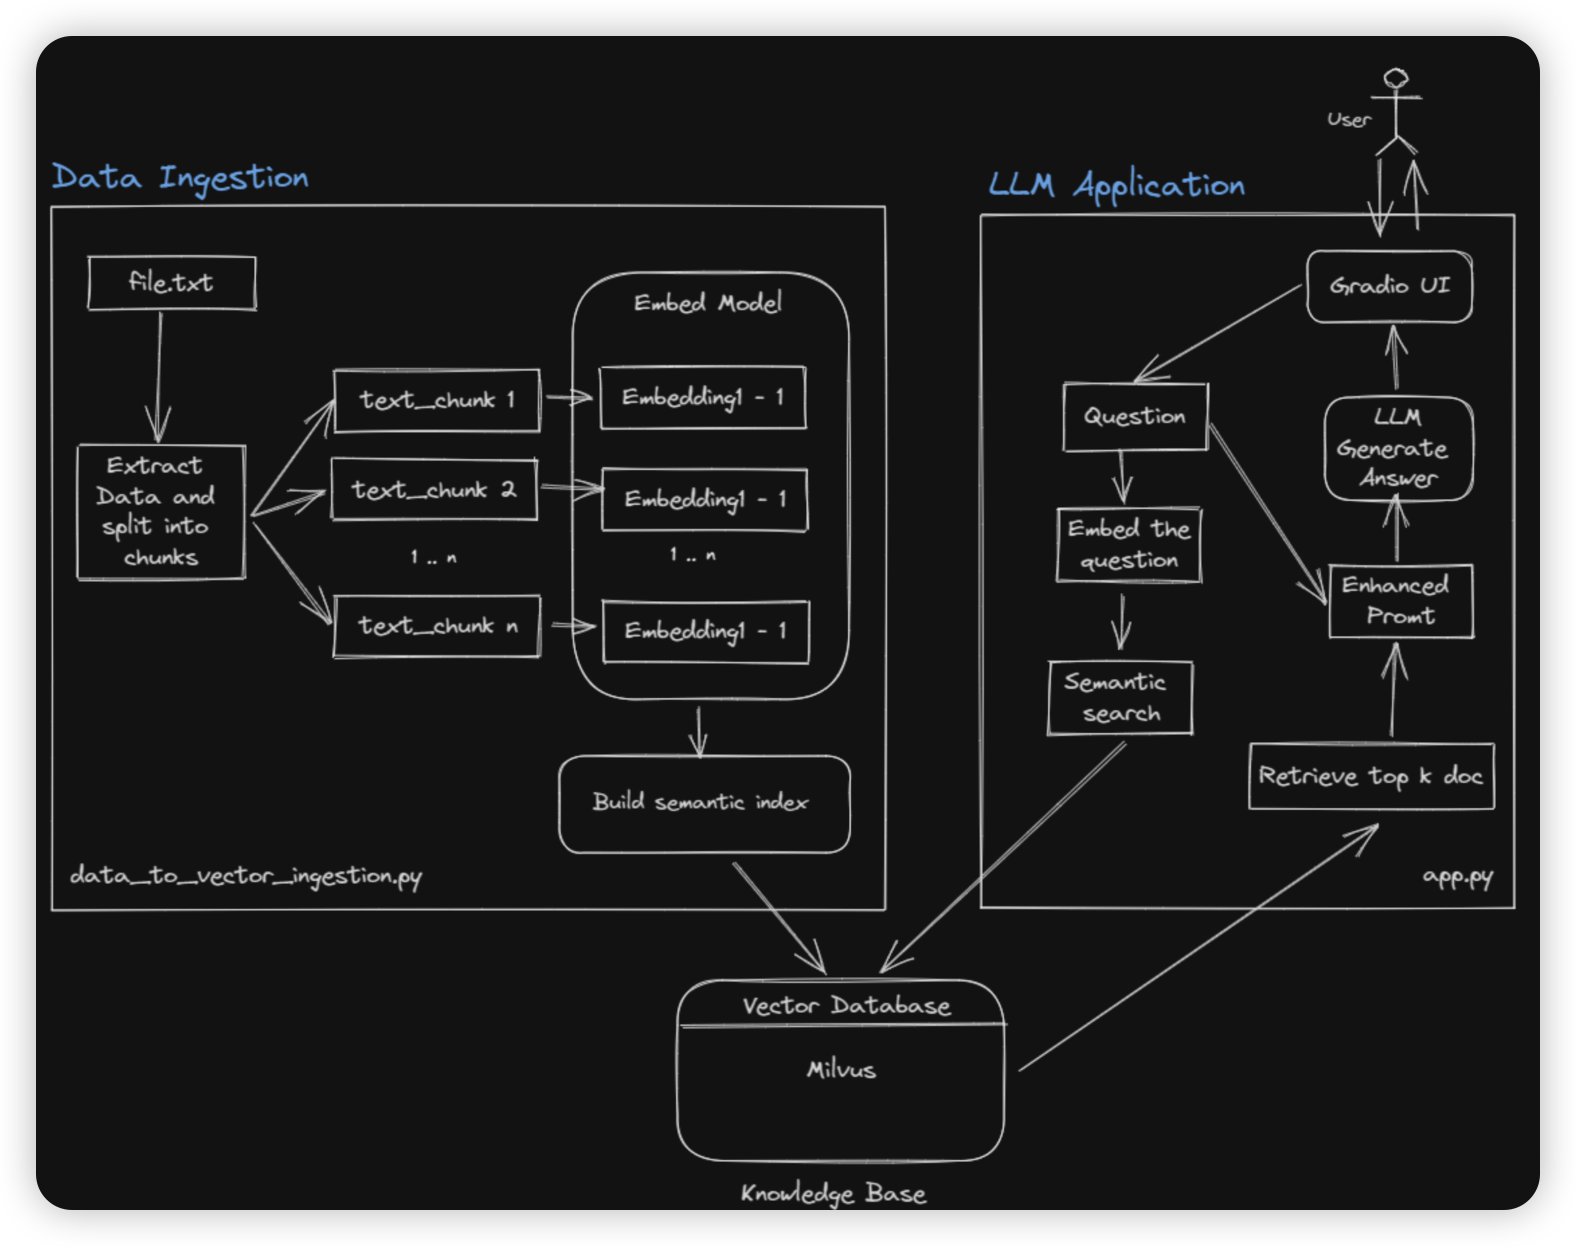

In [4]:
# Setup OpenAI keys
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")

### Data Ingestion

#### Extract data from txt file

In [5]:
# Load and process the text files
from langchain.document_loaders import TextLoader

loader = TextLoader('./data/single_text_file.txt')
documents = loader.load()

In [6]:
len(documents)

1

In [7]:
documents

[Document(metadata={'source': '../single_text_file.txt'}, page_content='this is a sample file')]

#### Chunking

In [8]:
# splitting the text into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(documents)

In [9]:
len(texts)

1

In [10]:
texts[0]

Document(metadata={'source': '../single_text_file.txt'}, page_content='this is a sample file')

#### Create chunk embeddings and store in vector Database and build indexes

In [11]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create a database in local disk
persist_directory = 'db'

# OpenAI Embeddings
embedding = OpenAIEmbeddings()

"""
Either create the embeddings by passing the chunk one by one and store in croma vector db
or simple pass the embedding function and let inbuilt function of Chroma db store embeddings of each chunk automatically
"""
vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

/var/folders/6c/8ssblrgx1fsbbb07vqpb8t580000gn/T/ipykernel_33292/3998108652.py:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings()


In [12]:
# persiste the db to disk
vectordb.persist()
vectordb = None

/var/folders/6c/8ssblrgx1fsbbb07vqpb8t580000gn/T/ipykernel_33292/2083128404.py:2: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


In [13]:
# Now we can load the persisted database from disk, and use it as normal.
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding)

/var/folders/6c/8ssblrgx1fsbbb07vqpb8t580000gn/T/ipykernel_33292/3229766805.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectordb = Chroma(persist_directory=persist_directory,


#### Initialise Croma DB Retriever 

In [14]:
retriever = vectordb.as_retriever(search_kwargs={"k": 2})
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f9e88829580>, search_kwargs={'k': 2})

In [15]:
docs = retriever.get_relevant_documents("sample doc")

/var/folders/6c/8ssblrgx1fsbbb07vqpb8t580000gn/T/ipykernel_33292/282952228.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs = retriever.get_relevant_documents("sample doc")
Number of requested results 2 is greater than number of elements in index 1, updating n_results = 1


In [16]:
retriever.search_type

'similarity'

In [17]:
retriever.search_kwargs

{'k': 2}

### LLM Application

#### Embed Question, Retrieve Relavant Context And Enhance the Prompt And Generate Answer

In [ ]:
## Chain
# Example of prompt chaining

# Prompt template
PROMPT_TEMPLATE = """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer
the question. If you don't know the answer, say that you
    don't know. DON'T MAKE UP ANYTHING.

{context}

---

Answer the question based on the above context: {question}
"""

In [20]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

"""
Langchain provides the framework to all this with one line of code
"""
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=OpenAI(),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

In [21]:
# full example
query = "How much money did Pando raise?"
llm_response = qa_chain(query)
llm_response

/var/folders/6c/8ssblrgx1fsbbb07vqpb8t580000gn/T/ipykernel_33292/3711342221.py:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  llm_response = qa_chain(query)
Number of requested results 2 is greater than number of elements in index 1, updating n_results = 1


{'query': 'How much money did Pando raise?',
 'result': " I don't know.",
 'source_documents': [Document(metadata={'source': '../single_text_file.txt'}, page_content='this is a sample file')]}

In [23]:
# Utility Funtion to beautify the output
def process_llm_response(llm_response):
    print(llm_response['result'])
    print('\n\nSources:')
    print("="*50)
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

In [24]:
# Lets understand it
process_llm_response(llm_response)

 I don't know.


Sources:
../single_text_file.txt


In [ ]:
"""
Any any step we have various other options, various different opensource LLMs, different embedding models, local CPU based model available.

Langchain provides the framework to quickly iterate and create LLM based applications.
"""